# Run AOS on real images

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
from flow_analysis_comps.processing.Fourier.OrientationSpaceManager import (
    orientationSpaceManager,
)
import colorcet  # noqa: F401
from flow_analysis_comps.data_structs.AOS_structs import OSFilterParams
from flow_analysis_comps.data_structs.kymographs import (
    graphExtractConfig,
    kymoExtractConfig,
)
from flow_analysis_comps.processing.graph_extraction.graph_extract import (
    VideoGraphExtractor,
)
from flow_analysis_comps.processing.kymographing.kymographer import KymographExtractor
import colorcet as cc

%matplotlib widget

%load_ext autoreload
%autoreload 2



In [ ]:
video_root_folder = Path(
    r"/Users/simonvanstaalduine/AMOLF-SHIMIZU Dropbox/Simon van Staalduine/033"
    # r"G:\AMOLF_Data\AMOLF-SHIMIZU Dropbox\Simon van Staalduine\033"
)
graph_data = VideoGraphExtractor(video_root_folder, graphExtractConfig()).edge_data
kymograph_list = KymographExtractor(
    graph_data, kymoExtractConfig()
).processed_kymographs

AOS_params = OSFilterParams(
    space_frequency_center=0.25,
    space_frequency_width=0.3,
    orientation_accuracy=8.0,
    x_spacing=kymograph_list[0].deltas.delta_x,
    y_spacing=kymograph_list[0].deltas.delta_t,
)
AOS_manager = orientationSpaceManager(AOS_params, kymograph_list[0].kymo_no_static)

angles_dict = AOS_manager.get_all_angles()

In [ ]:
angles_response = AOS_manager.refine_all_angles(4.0, angles_dict)

In [ ]:
from flow_analysis_comps.visualizing.kymographs import kymoVisualizer
from flow_analysis_comps.visualizing.AOSFilterVisualizer import AOSVisualizer

AOS_viz = AOSVisualizer(AOS_params)
AOS_viz.demo_image(AOS_manager)

# Test with test data

45 135


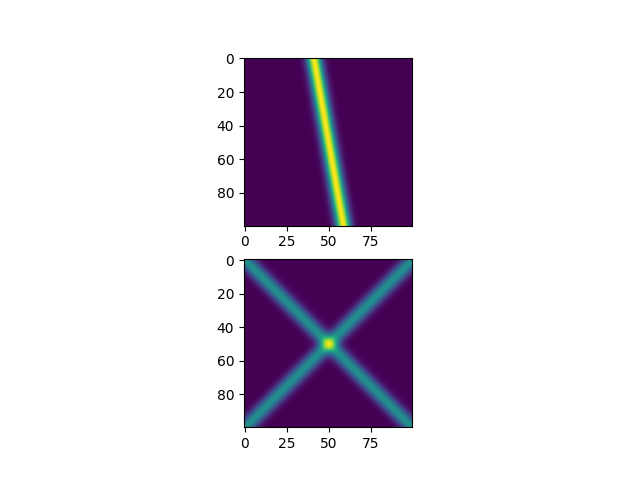

In [101]:
from flow_analysis_comps.test_data import single_line_img, crossing_line_img
import numpy as np

test_single = single_line_img(80)
test_crossing = crossing_line_img([45, 180-45], [3, 3])

print(45, 180-45)

fig, ax = plt.subplots(2)
ax[0].imshow(test_single)
ax[1].imshow(test_crossing)

In [108]:
AOS_params = OSFilterParams(
    space_frequency_center=.1,
    # space_frequency_width=0.3,
    orientation_accuracy=5.0,
    x_spacing=1,
    y_spacing=1,
)
AOS_manager = orientationSpaceManager(AOS_params, test_crossing)
angles_dict = AOS_manager.get_max_angles()
nlms_mask = AOS_manager.nlms_simple_case()

In [109]:

full_orientation = np.rad2deg(angles_dict)
nlms_orientation = np.where(nlms_mask, np.rad2deg(angles_dict), np.nan)

(array([0.        , 0.        , 0.00461042, 0.        , 0.00230521,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00461042,
        0.        , 0.00691562, 0.        , 0.        , 0.00461042,
        0.        , 0.        , 0.00461041, 0.00461042, 0.13831265,
        0.07837717, 0.00461042, 0.00922082, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.00230521, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.00230521, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.00230522, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.00

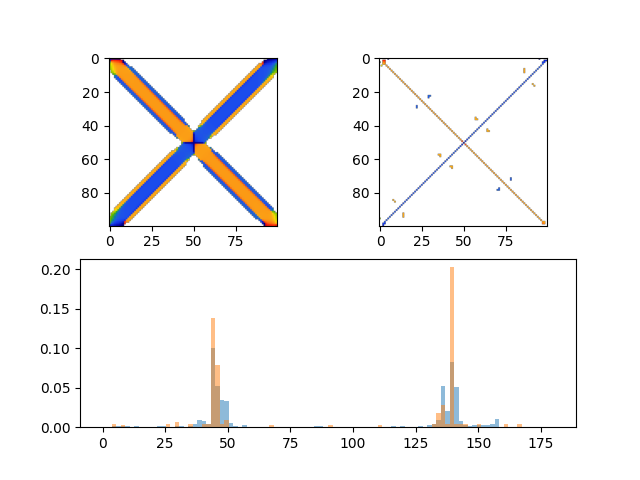

In [110]:
from flow_analysis_comps.visualizing.AOSFilterVisualizer import AOSVisualizer
import numpy as np

# angles_max_max = np.nanmax(angles_dict["angles_maxima"].real, axis=0)
# print(angles_dict.keys())

fig, ax = plt.subplot_mosaic([["Orientation", "NLMS_orientation"], ["Histograms", "Histograms"]])
ax["Orientation"].imshow(full_orientation, cmap=cc.cm.rainbow4, vmin=0, vmax=180)
ax["NLMS_orientation"].imshow(nlms_orientation, cmap=cc.cm.rainbow4, vmin=0, vmax=180)
ax["Histograms"].hist(full_orientation.flatten(), bins=100, range=(0, 180), density=True, alpha=.5)
ax["Histograms"].hist(nlms_orientation.flatten(), bins=100, range=(0, 180), density=True, alpha=.5)


[ 0  1  2  3  4  5 -5 -4 -3 -2 -1]
[-5 -4 -3 -2 -1  0  1  2  3  4  5]


/Users/simonvanstaalduine/Software_projects/flow_analysis_comps/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/simonvanstaalduine/Software_projects/flow_analysis_comps/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


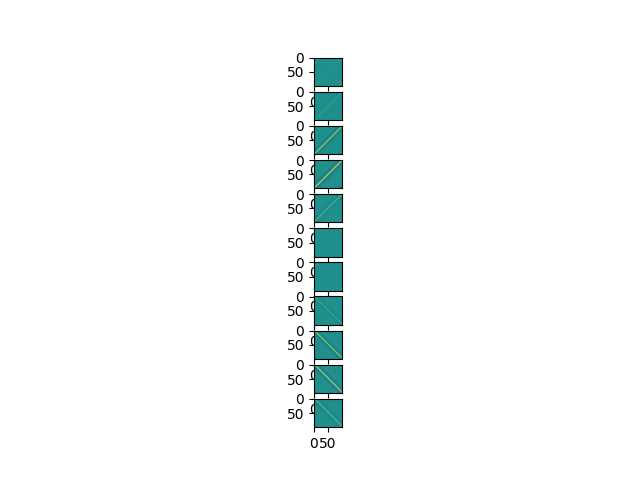

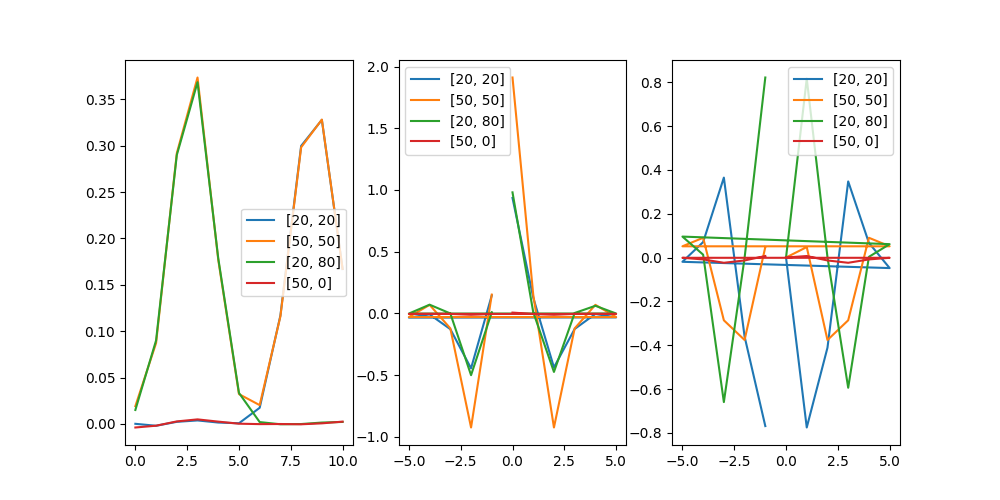

In [111]:
filter_stack = np.moveaxis(AOS_manager.response.response_stack, 2, 0)

nyquist = int(np.ceil((len(filter_stack) + 1) / 2))
response_frequencies = np.concatenate([np.arange(nyquist), -np.arange(nyquist - 1, 0, -1)])
response_frequencies_full = response_frequencies[..., np.newaxis, np.newaxis]  # Add new axis for broadcasting

filter_stack_fft = np.fft.fft(filter_stack, axis=0)
response_fft_derivative1 = filter_stack_fft * (1j * response_frequencies_full)
# response_fft_derivative2 = filter_stack_fft * -(response_frequencies_full**2)

filter_stack_fft_shift = np.fft.fftshift(filter_stack_fft, axes=0)
print(response_frequencies)
print(np.fft.fftshift(response_frequencies))

fig, ax = plt.subplots(len(filter_stack))
for i, img in enumerate(filter_stack):
    ax[i].imshow(img.real, vmin=-.5, vmax=.5)

points = [[20, 20], [50, 50], [20, 80], [50, 0]]

fig, ax = plt.subplots(1, 3, figsize=(10, 5))

for point in points:
    ax[0].plot(filter_stack[:, *point], label=f"{point}")
    ax[1].plot(response_frequencies, filter_stack_fft[:, *point], label=f"{point}")
    ax[2].plot(response_frequencies, response_fft_derivative1[:, *point], label=f"{point}")

ax[0].legend()
ax[1].legend()
ax[2].legend()

In [131]:
# print(response_fft_derivative1[:, *points[0]])
sequence_fft = response_fft_derivative1[:, *points[2]]

N = len(sequence_fft)
K = N // 2
c = np.fft.fftshift(sequence_fft)

c /= c[-1]
n = N
companion = np.zeros((n,n), dtype=np.complex128)
companion[1:, :-1] = np.eye(n-1, dtype=np.complex128)
companion[0, 1:] = c[:-1][::-1]
roots = np.linalg.eigvals(companion)
magnitudes = abs(roots)

angles= np.log(roots)
angles = np.rad2deg(np.angle(angles * -1j/2)) 
# angles = np.where(abs(np.log(magnitudes)) < .9, angles, -1)
print(companion)
print(angles)
print(magnitudes)

[[  0.        +0.00000000e+00j  -0.02492414+4.07843757e+00j
   -9.73860121+1.31974886e-02j   0.31126749-1.55083423e+01j
   13.36904938+4.35602529e-01j   0.        +0.00000000e+00j
   13.46052864+9.10497009e-02j  -0.32747274+1.63683471e+01j
  -10.80588397-2.11374484e-01j   0.29864309-4.66333049e+00j
    1.56356897+8.67209598e-02j]
 [  1.        +0.00000000e+00j   0.        +0.00000000e+00j
    0.        +0.00000000e+00j   0.        +0.00000000e+00j
    0.        +0.00000000e+00j   0.        +0.00000000e+00j
    0.        +0.00000000e+00j   0.        +0.00000000e+00j
    0.        +0.00000000e+00j   0.        +0.00000000e+00j
    0.        +0.00000000e+00j]
 [  0.        +0.00000000e+00j   1.        +0.00000000e+00j
    0.        +0.00000000e+00j   0.        +0.00000000e+00j
    0.        +0.00000000e+00j   0.        +0.00000000e+00j
    0.        +0.00000000e+00j   0.        +0.00000000e+00j
    0.        +0.00000000e+00j   0.        +0.00000000e+00j
    0.        +0.00000000e+00j]
 [  

In [35]:
angles_all = AOS_manager.get_all_angles()
angles_max = np.nanmax(angles_all["maxima_value"], axis=0)

Finding roots: 100%|██████████| 10000/10000 [00:00<00:00, 27906.36it/s]
/var/folders/58/nzm36xss7sj9nr55h66f1t800000gn/T/ipykernel_34546/4063381545.py:2: RuntimeWarning: All-NaN slice encountered
  angles_max = np.nanmax(angles_all["maxima_value"], axis=0)


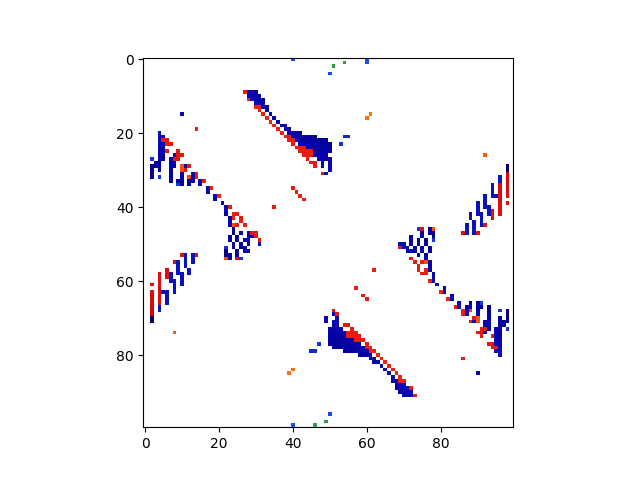

In [36]:
plt.figure()
plt.imshow(np.rad2deg(angles_all["angles_maxima"][0]), vmin=0, vmax=360, cmap=cc.cm.rainbow4)